<a href="https://colab.research.google.com/github/BhavaniAM/Satellite-Image-Classification/blob/main/Satellite_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Satellite Image Classification
---



In [ ]:
#import the necessary libraries
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt
from skimage.io import imshow
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Sequential
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading the dataset
# dataset used: https://www.kaggle.com/crawford/deepsat-sat4
# has 4 classes and the total number of images = 1000000
# values are in the .csv file 
# X contains the images and Y contains the labels corresponding to the images in the dataset
X = pd.read_csv('/content/drive/MyDrive/NNDL_Project/X_test_sat4.csv') 
Y = pd.read_csv('/content/drive/MyDrive/NNDL_Project/y_test_sat4.csv')

In [ ]:
# Shape of the training data 
print("Training dataset: ",X.shape)

# converting the dataframe to numpy arrays
X = np.array(X) 
Y = np.array(Y)

Training dataset:  (99999, 3136)


In [ ]:
# Reshaping (99999, 3136) to (99999, 28, 28, 4) 
# Has 4 channels (RGB and Alpha. Alpha indicates the transparency). The image size is now 28x28x4

X = X.reshape([99999,28,28,4]).astype(float) 
print("Reshaped dataset: ",X.shape)

Reshaped dataset:  (99999, 28, 28, 4)


In [ ]:
# Splitting the data into train and test datasets
from sklearn.model_selection import train_test_split

# Using 80% of the dataset as training dataset and 20% as the unseen test dataset
# Initializing random_state = 0 makes sure that the train and the test datasets are the same each time the code is run
# Otherwise the datasets will differ and the results will be unpredictable
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0) 

# y_train and y_test are 1x4 one-hot encoded vectors that contain the labels

# format of train and test data
print("X_train data shape: ",x_train.shape)
print("Y_train data shape: ",y_train.shape)
print("X_test data shape: ",x_test.shape)
print("Y_test data shape: ",y_test.shape)

X_train data shape:  (79999, 28, 28, 4)
Y_train data shape:  (79999, 4)
X_test data shape:  (20000, 28, 28, 4)
Y_test data shape:  (20000, 4)


In [ ]:
# Normalize the pixel values in the train and test datasets to a value in (0,1)
# This is to reduce the computation of high numeric values. Each pixel value represents a color code.
x_train = x_train/255
x_test = x_test/255

Image number:  4954


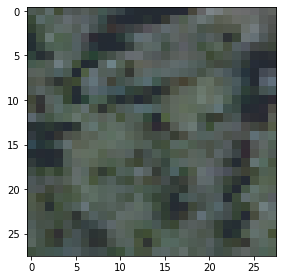

Ground Truth: Forest Land


In [ ]:
# Images in the data with their label (reduced image size of 28x28x4)
# There are now 80000 images in the training dataset
# We pick a random image from the dataset in the range (0,79999)
img_no = random.randint(0,79999) 
print("Image number: ", img_no)
# On using the alpha channel the image has a low data range. 
# The image is not correctly displayed and has a rather stretched contrast
# Display the image using the RGB format. We are showing only 3 channels here (RGB)
imshow(np.squeeze(x_train[img_no,:,:,0:3]).astype(float)) 
plt.show()

# y_train has the parameters as the image number and the class label
# The ground truth (label) associated with a random image picked from the dataset is printed
# y_train[img_no] == [1,0,0,0] Barren land
# y_train[img_no] == [0,1,0,0] Forest land
# y_train[img_no] == [0,0,1,0] Grassland
# y_train[img_no] == [0,0,0,1] Other

print ('Ground Truth: ',end='')
if y_train[img_no, 0] == 1:
    print ('Barren Land')
elif y_train[img_no, 1] == 1:
    print ('Forest Land')
elif y_train[img_no, 2] == 1:
    print ('Grassland')
else:
    print ('Other')

In [ ]:
# defining the CNN layers
from keras.layers.advanced_activations import LeakyReLU
from keras import *
num_classes = 4
# linear stack of layers
model = Sequential()
# The output spatial volume is decreasing as our number of filters learned is increasing.
# The number of filters are specified in increasing orders of powers of 2. This is based on the complexity of the network
# padding = "same" ensures that the output and the input volume have the same dimensions

# kernel_size = a 2-tuple specifying the width and height of the 2D convolution window. 
# if input image size < 128x128, use kernel size 3x3 (based on how much spatial volume you want to reduce)
# stride is (1,1) (default)
# LeakyReLU: allows a small gradient when the unit is not active

model.add(Conv2D(32, kernel_size=(3, 3),input_shape=(28,28,4),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv2D(64, (3, 3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv2D(128, (3, 3),padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

# The last fully connected layer for classification
model.add(Flatten()) # Converts the matrix to a vector
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
# Activation function used : Softmax. Introduces non-linearity
# A neural network without an activation function is essentially just a linear regression model. 
model.add(Dense(num_classes, input_shape=(3136,), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#x.get_weights()[0][:,:,0,:]
model.summary()

# weights in conv2D (Param) = (num_filters * filter_size * filter_size * num_channels) + num_filters
# weights in Dense = (num_neurons * num_inputs) + num_neurons   ((128*2048) + 128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        1184      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [ ]:
#fitting the data into the model
model_pred = model.fit(x_train,y_train,batch_size=64, epochs=20, verbose=1, validation_split=0.20)

Epoch 1/20
1000/1000 [==============================] - 22s 13ms/step - loss: 0.2332 - accuracy: 0.9111 - val_loss: 0.0914 - val_accuracy: 0.9699
Epoch 2/20
1000/1000 [==============================] - 13s 13ms/step - loss: 0.1037 - accuracy: 0.9636 - val_loss: 0.1119 - val_accuracy: 0.9606
Epoch 3/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0797 - accuracy: 0.9716 - val_loss: 0.0628 - val_accuracy: 0.9798
Epoch 4/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0693 - accuracy: 0.9760 - val_loss: 0.0728 - val_accuracy: 0.9741
Epoch 5/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0593 - accuracy: 0.9789 - val_loss: 0.0690 - val_accuracy: 0.9748
Epoch 6/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0532 - accuracy: 0.9809 - val_loss: 0.0600 - val_accuracy: 0.9805
Epoch 7/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0522 - accuracy: 0.9824 - val_loss: 0.0699 -

Image number:  327


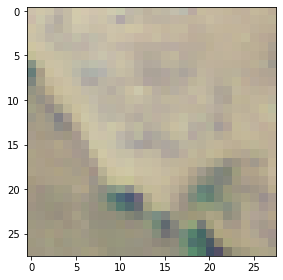

625/625 [==============================] - 2s 3ms/step
(20000, 4)
Predicted Label: Barren Land
Actual label: Barren Land


In [ ]:
# Picking an image from the test dataset. The test dataset has 20000 images
img_no = random.randint(0,19999)
print("Image number: ",img_no)
imshow(np.squeeze(x_test[img_no,:,:,0:3]).astype(float)) 
plt.show()

# Predicted classification
preds = model.predict(x_test, verbose=1)
print(preds.shape)
print ('Predicted Label: ',end='')
if preds[img_no, 0]*100  >= 80:
    print ('Barren Land')
elif preds[img_no, 1]*100 >= 80:
    print ('Forest Land')
elif preds[img_no, 2]*100 >= 80:
    print ('Grassland')
else:
    print ('Other')

# Actual classification
print ('Actual label: ',end='')
if y_test[img_no, 0] == 1:
    print ('Barren Land')
elif y_test[img_no, 1] == 1:
    print ('Forest Land')
elif y_test[img_no, 2] == 1:
    print ('Grassland')
else:
    print ('Other')

In [ ]:
# model performance evaluation

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy score: ",accuracy_score(y_test, np.round_(preds)))
print("Classification report:")
print(classification_report(y_test, np.round_(preds)))
print("Accuracy of CNN model is: ", accuracy_score(y_test,np.round_(preds))*100)

# Precision = TP/(TP+FP) (Out of all the positive predicted, what percentage is truly positive)
# Recall = TP/(TP+FN)    (Out of the total positive, what percentage are predicted positive)
# F1 score = 2PR/(P+R)   (Harmonic mean of Precision and Recall)
# Support                (the number of actual occurrences of the class in the specified dataset)

Accuracy score:  0.9894
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5223
           1       1.00      1.00      1.00      4121
           2       0.97      0.98      0.98      3596
           3       1.00      1.00      1.00      7060

   micro avg       0.99      0.99      0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000
 samples avg       0.99      0.99      0.99     20000

Accuracy of CNN model is:  98.94


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


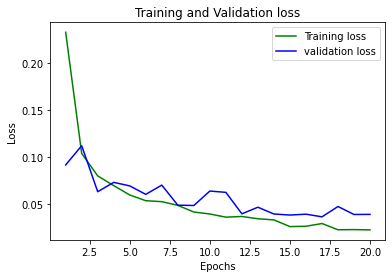

In [ ]:
# Overfitting: Train loss decreases but the validation loss increases

train_loss = model_pred.history['loss']
val_loss = model_pred.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

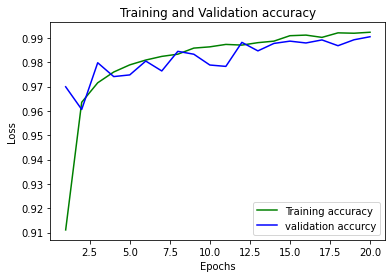

In [ ]:
# Overfitting: training accuracy is much higher than the validation accuracy

acc_train = model_pred.history['accuracy']
acc_val = model_pred.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accurcy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()